In [9]:
import pandas as pd
from river import compose
from river import linear_model
from river import metrics
from river import preprocessing
from river import stream
from sklearn.feature_selection import SelectKBest, f_regression
import matplotlib.pyplot as plt
import numpy as np
from meteostat import Point, Hourly
import matplotlib.dates as mdates



In [10]:
# Load the data
df = pd.read_csv('residential4_grid_import_export_weather_fixed_timestamps.csv')

#update grid import to be difranced
df['DE_KN_residential4_grid_import'] = df['DE_KN_residential4_grid_import'].diff()
print(df['DE_KN_residential4_grid_import'])

# set first value to 0
df['DE_KN_residential4_grid_import'].iloc[0] = 0

# Convert the 'utc_timestamp' column to datetime
df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'])
print(df['utc_timestamp'])

# Extract day of the week and hour of the day
df['day_of_week'] = df['utc_timestamp'].dt.dayofweek
df['hour_of_day'] = df['utc_timestamp'].dt.hour
df['month'] = df['utc_timestamp'].dt.month

# Define the features and the target
features = ['hour_of_day','day_of_week','month', 'temp','season_Summer','season_Winter','season_Spring','season_Autumn','holiday']

target = 'DE_KN_residential4_grid_import'

# Create a feature selector
selector = SelectKBest(score_func=f_regression, k=5)

# Fit the selector to the data
selector.fit(df[features], df[target])

# Get the selected features
mask = selector.get_support()
selected_features = [f for f, m in zip(features, mask) if m]

print(f'Selected features: {selected_features}')

df.set_index('utc_timestamp', inplace=True)


0             NaN
1        0.039682
2        0.030990
3        0.075048
4        0.175761
           ...   
81430    0.295898
81431    0.279297
81432    0.145508
81433    0.219727
81434    0.209961
Name: DE_KN_residential4_grid_import, Length: 81435, dtype: float64
0       2015-10-10 16:30:00
1       2015-10-10 16:45:00
2       2015-10-10 17:00:00
3       2015-10-10 17:15:00
4       2015-10-10 17:30:00
                ...        
81430   2018-02-04 22:00:00
81431   2018-02-04 22:15:00
81432   2018-02-04 22:30:00
81433   2018-02-04 22:45:00
81434   2018-02-04 23:00:00
Name: utc_timestamp, Length: 81435, dtype: datetime64[ns]
Selected features: ['hour_of_day', 'temp', 'season_Summer', 'season_Winter', 'season_Spring']


You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


MAE: 0.8730192953808398


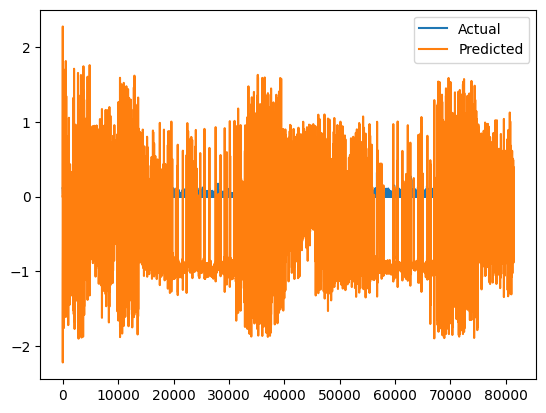

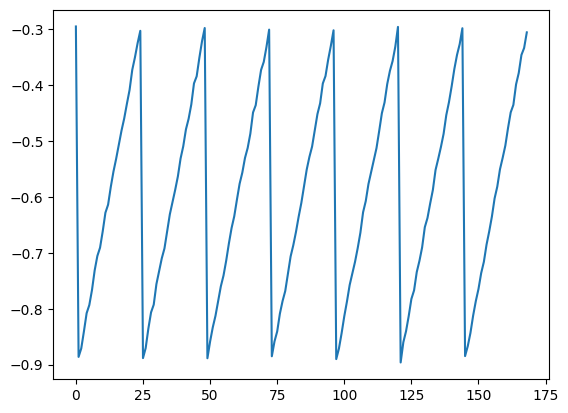

In [11]:
# Create a model
model = compose.Pipeline(
    preprocessing.StandardScaler(),
    linear_model.PARegressor()
)

# Define a metric
metric = metrics.MAE()

# Prepare lists to store the actual and predicted values
actuals = []
predictions = []


df = df.rolling(window=20).mean()

#drop na values
df = df.dropna()

#print (df)
# Iterate over the data and update the model and the metric
for xi, yi in stream.iter_pandas(df[selected_features], df[target]):
    y_pred = model.predict_one(xi) if model else None
    model.learn_one(xi, yi)
    if y_pred is not None:
        metric.update(yi, y_pred)
        actuals.append(yi)
        predictions.append(y_pred)

print(f'MAE: {metric.get()}')

# Plot the actual vs predicted values
plt.plot(actuals, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

# Predict for the next 7 days
start_date = df.index.max() + pd.Timedelta(days=1)

end_date = start_date + pd.Timedelta(days=7)
dates = pd.date_range(start_date, end_date, freq='h')

predictions_next_week = []
for date in dates:
    xi = {
        'hour_of_day': date.hour,
        'day_of_week': date.dayofweek,
        'month': date.month,
        # Fill in the other features as appropriate
        #'DE_KN_residential4_grid_export': np.random.rand(),  # Example: random value
        'temp': np.random.rand(),  # Example: random value
        'season_Summer': 1 if date.month in [6, 7, 8] else 0,
        'season_Winter': 1 if date.month in [12, 1, 2] else 0,
        'season_Spring': 1 if date.month in [3, 4, 5] else 0,
        'season_Autumn': 1 if date.month in [9, 10, 11] else 0,
        'holiday': 0  # Example: no holidays
    }
    y_pred = model.predict_one(xi)
    predictions_next_week.append(y_pred)

# Plot the predictions for the next week
plt.plot(predictions_next_week)
plt.show()


MAE: 0.056182030266860056


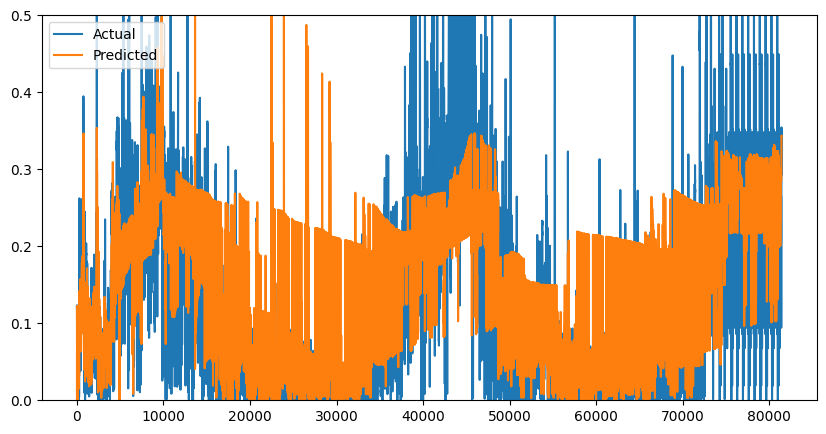

In [12]:
from river import compose
from river import linear_model
from river import metrics
from river import preprocessing
from river import stats
from river import stream
from river import tree
import river
import numpy as np

# Create a model
model = compose.Pipeline(
    preprocessing.StandardScaler(),
    tree.HoeffdingTreeRegressor()
)

# Define a metric
metric = metrics.MAE()

# Prepare lists to store the actual and predicted values
actuals = []
predictions = []

# Iterate over the data and update the model and the metric
for xi, yi in stream.iter_pandas(df[selected_features], df[target]):
    y_pred = model.predict_one(xi) if model else None
    model.learn_one(xi, yi)
    if y_pred is not None:
        metric.update(yi, y_pred)
        actuals.append(yi)
        #print both actual and predicted values
        #print(f'Actual: {yi}, Predicted: {y_pred}')    
        
        predictions.append(y_pred)

print(f'MAE: {metric.get()}')


# Plot the actual and predicted values
plt.figure(figsize=(10, 5))
plt.plot(actuals, label='Actual')
plt.plot(predictions, label='Predicted')
plt.ylim(0, 0.5)
plt.legend()
plt.show()












MAE for Linear Regression: 23483140071.020454
MAE for KNN Regressor: 0.03338828620271264
MAE for Hoeffding Tree Regressor: 0.056182030266860056


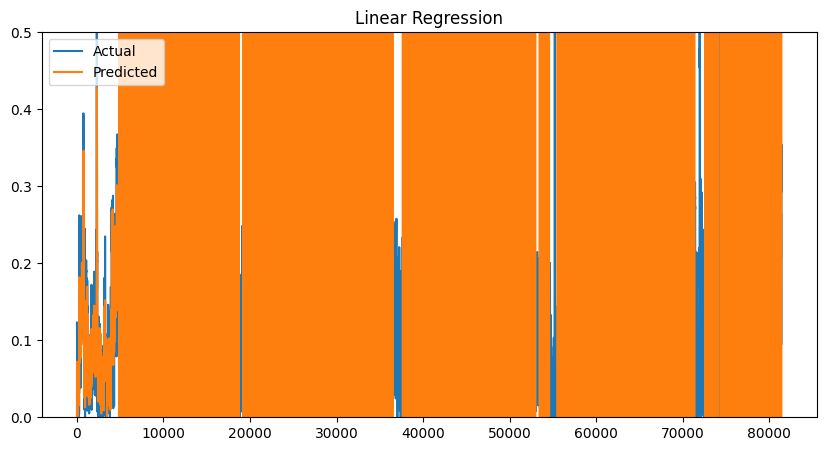

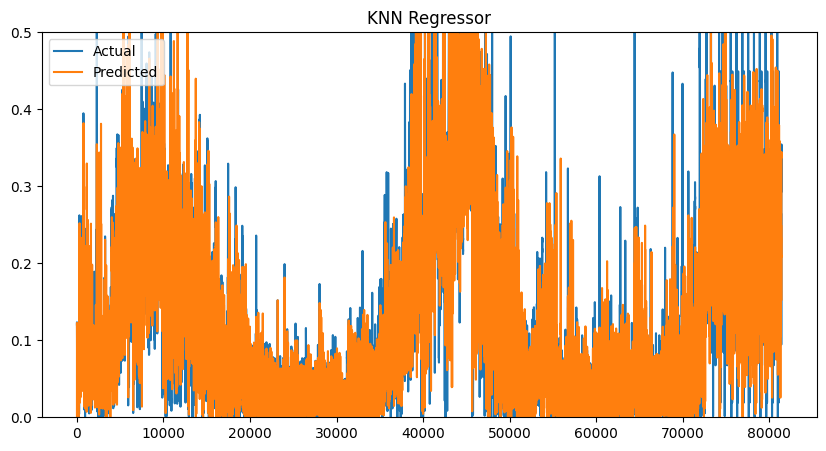

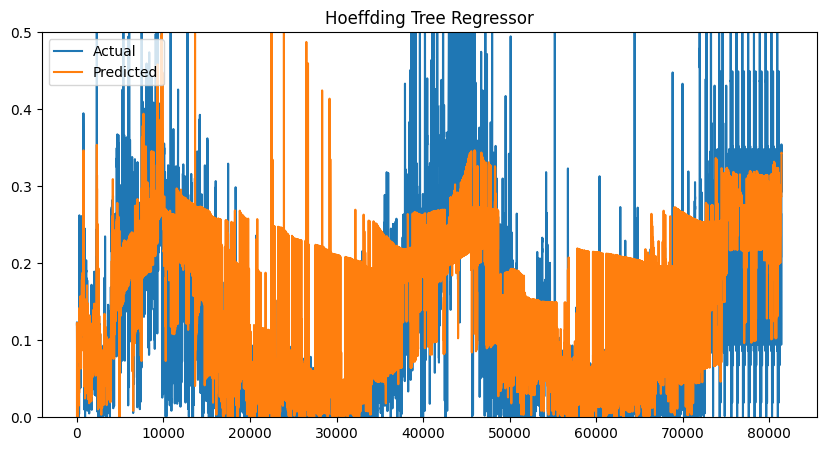

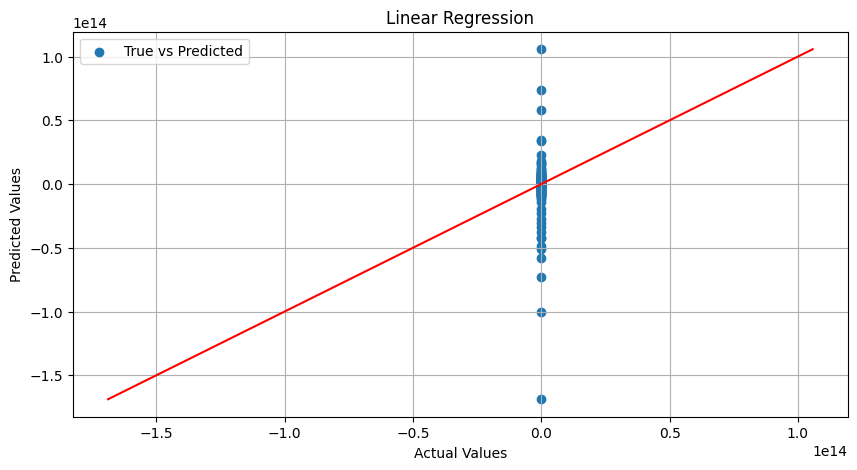

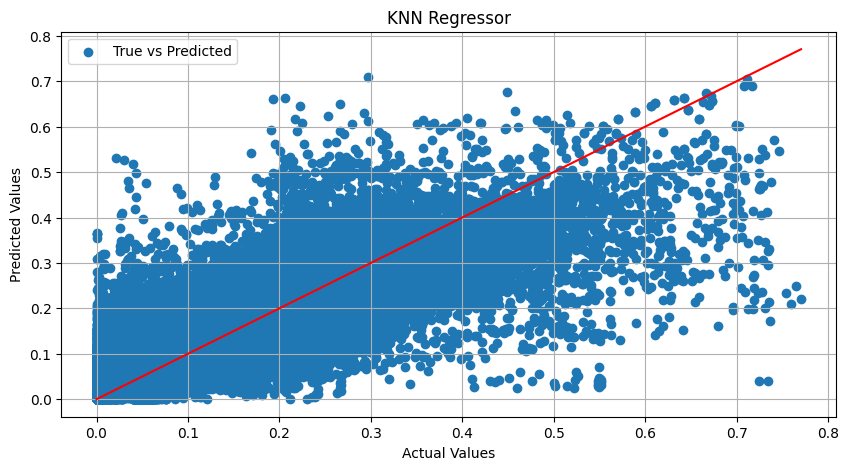

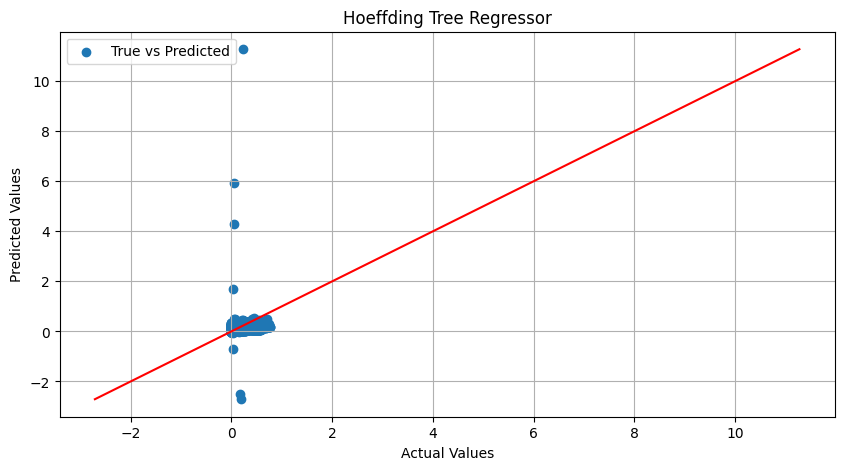

In [13]:
from river import compose
from river import linear_model
from river import metrics
from river import preprocessing
from river import stream
from river import tree
from river import neighbors
import matplotlib.pyplot as plt

# Define the models
models = {
    "Linear Regression": linear_model.LinearRegression(),
    "KNN Regressor": neighbors.KNNRegressor(),
    "Hoeffding Tree Regressor": tree.HoeffdingTreeRegressor()
}

# Prepare a dictionary to store the actual and predicted values for each model
results = {model_name: {"actuals": [], "predictions": []} for model_name in models.keys()}

# Iterate over the models
for model_name, model in models.items():
    # Create a pipeline with preprocessing and the model
    model = compose.Pipeline(
        preprocessing.StandardScaler(),
        model
    )

    # Define a metric
    metric = metrics.MAE()

    # Iterate over the data and update the model and the metric
    for xi, yi in stream.iter_pandas(df[selected_features], df[target]):
        y_pred = model.predict_one(xi) if model else None
        model.learn_one(xi, yi)
        if y_pred is not None:
            metric.update(yi, y_pred)
            results[model_name]["actuals"].append(yi)
            results[model_name]["predictions"].append(y_pred)

    print(f'MAE for {model_name}: {metric.get()}')

# Plot the actual and predicted values for each model
for model_name, result in results.items():
    plt.figure(figsize=(10, 5))
    plt.plot(result["actuals"], label='Actual')
    plt.plot(result["predictions"], label='Predicted')
    plt.ylim(0, 0.5)
    plt.title(model_name)
    plt.legend()
    plt.show()


# Plot the actual and predicted values for each model
for model_name, result in results.items():
    plt.figure(figsize=(10, 5))
    plt.scatter(result["actuals"], result["predictions"], label='True vs Predicted')
    
    # Add a red line for perfect predictions
    min_val = min(min(result["actuals"]), min(result["predictions"]))
    max_val = max(max(result["actuals"]), max(result["predictions"]))
    plt.plot([min_val, max_val], [min_val, max_val], color='red')
    
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    
    #set x and y limet
    plt.xlim(0, 0.8)
    plt.ylim(0, 0.8)
    
    plt.title(model_name)
    plt.grid(True)
    plt.legend()
    plt.show()
    
    


Finished evaluating model 1 of 5
Finished evaluating model 2 of 5
Finished evaluating model 3 of 5
Finished evaluating model 4 of 5
Finished evaluating model 5 of 5


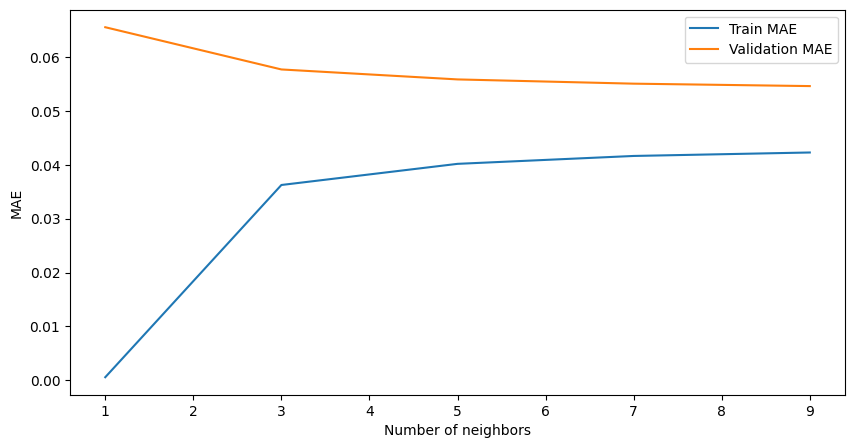

In [14]:
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Define the range of neighbors to test
#set the neighbors to every 100th value from 1 to 200
n_neighbors_values = np.arange(1, 10, 2)

# Prepare your data
X = df[selected_features].values
y = df[target].values

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Prepare a dictionary to store the results
results = {}

# Define the number of folds
n_folds = 5

# Create the KFold object
kf = KFold(n_splits=n_folds)

# Iterate over the number of neighbors
for i, n_neighbors in enumerate(n_neighbors_values, 1):
    # Prepare lists to store the MAE for each fold
    train_maes = []
    valid_maes = []

    # Iterate over the folds
    for train_index, valid_index in kf.split(X):
        # Split the data into training and validation sets
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]

        # Create and train the model
        model = KNeighborsRegressor(n_neighbors=n_neighbors)
        model.fit(X_train, y_train)

        # Make predictions and calculate the MAE for the training set
        y_train_pred = model.predict(X_train)
        train_mae = mean_absolute_error(y_train, y_train_pred)
        train_maes.append(train_mae)

        # Make predictions and calculate the MAE for the validation set
        y_valid_pred = model.predict(X_valid)
        valid_mae = mean_absolute_error(y_valid, y_valid_pred)
        valid_maes.append(valid_mae)

    # Store the average MAE for the training and validation sets
    results[n_neighbors] = {"train_mae": np.mean(train_maes), "valid_mae": np.mean(valid_maes)}

    # Print a progress update
    print(f'Finished evaluating model {i} of {len(n_neighbors_values)}')

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(n_neighbors_values, [results[n]["train_mae"] for n in n_neighbors_values], label='Train MAE')
plt.plot(n_neighbors_values, [results[n]["valid_mae"] for n in n_neighbors_values], label='Validation MAE')
plt.xlabel('Number of neighbors')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [15]:
steps_ahead = 4 * 24 * 365  # Number of 15-minute intervals in a year

# Create a model
model = compose.Pipeline(
    preprocessing.StandardScaler(),
    neighbors.KNNRegressor(n_neighbors=10)
)

# Define a metric
metric = metrics.MAE()

# Prepare lists to store the actual and predicted values
actuals = []
predictions = []

# Iterate over the data and update the model and the metric
for xi, yi in stream.iter_pandas(df[selected_features], df[target]):
    y_pred = model.predict_one(xi) if model else None
    model.learn_one(xi, yi)
    if y_pred is not None:
        metric.update(yi, y_pred)
        actuals.append(yi)
        predictions.append(y_pred)

print(f'MAE: {metric.get()}')


# Create Point for Brussels
location = Point(50.8503, 4.3517)

# Get the last date in your existing data
last_date = df.index.max()

# Calculate the start and end dates based on the steps_ahead variable
start = last_date + pd.Timedelta(minutes=15)
end = start + pd.Timedelta(minutes=15*steps_ahead)


# Get hourly data for the specified period
weather_data = Hourly(location, start, end)
weather_data = weather_data.fetch()

# Interpolate to every 15 minutes
weather_data = weather_data.resample('15min').interpolate()

# Add a column for weather type
weather_data['weather_type'] = weather_data['prcp']
#print(weather_data)
# Select only the temperature and weather type columns
weather_data = weather_data[['temp']]
print(weather_data.index.min())
#print(weather_data)
# Calculate the start and end dates for the predictions
start_date = pd.Timestamp(weather_data.index.min())
print(start_date)
print(weather_data.index.max())
end_date = weather_data.index.max()
print(end_date)
dates = pd.date_range(start_date, end_date, freq='15min')
print(dates)


predictions_next_year = []
for date in dates:
    # Get the weather data for this date

    temp = weather_data.loc[date, 'temp']
    xi = {
        'hour_of_day': date.hour,
        'day_of_week': date.dayofweek,
        'month': date.month,
        'temp': temp,  # Use the actual temperature
        'season_Summer': 1 if date.month in [6, 7, 8] else 0,
        'season_Winter': 1 if date.month in [12, 1, 2] else 0,
        'season_Spring': 1 if date.month in [3, 4, 5] else 0,
        'season_Autumn': 1 if date.month in [9, 10, 11] else 0,
        'holiday': 0  # Example: no holidays
    }
    y_pred = model.predict_one(xi)
    predictions_next_year.append(y_pred)

print(dates)
# Plot the predictions for the next year
plt.figure(figsize=(12, 6))
plt.plot(dates, predictions_next_year)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()
plt.show()



#show the actual values for that year
plt.figure(figsize=(12, 6))
plt.plot(df.index, df[target])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()
plt.show()









In [ ]:
steps_ahead = 4 * 24 * 365  # Number of 15-minute intervals in a year

# Create a model
model = compose.Pipeline(
    preprocessing.StandardScaler(),
    linear_model.PARegressor()
)

# Define a metric
metric = metrics.MAE()

# Prepare lists to store the actual and predicted values
actuals = []
predictions = []

# Iterate over the data and update the model and the metric
for xi, yi in stream.iter_pandas(df[selected_features], df[target]):
    y_pred = model.predict_one(xi) if model else None
    model.learn_one(xi, yi)
    if y_pred is not None:
        metric.update(yi, y_pred)
        actuals.append(yi)
        predictions.append(y_pred)

print(f'MAE: {metric.get()}')


# Create Point for Brussels
location = Point(50.8503, 4.3517)

# Get the last date in your existing data
last_date = df['utc_timestamp'].max()

# Calculate the start and end dates based on the steps_ahead variable
start = last_date + pd.Timedelta(minutes=15)
end = start + pd.Timedelta(minutes=15*steps_ahead)


# Get hourly data for the specified period
weather_data = Hourly(location, start, end)
weather_data = weather_data.fetch()

# Interpolate to every 15 minutes
weather_data = weather_data.resample('15min').interpolate()

# Add a column for weather type
weather_data['weather_type'] = weather_data['prcp']
#print(weather_data)
# Select only the temperature and weather type columns
weather_data = weather_data[['temp']]
print(weather_data.index.min())
#print(weather_data)
# Calculate the start and end dates for the predictions
start_date = pd.Timestamp(weather_data.index.min())
print(start_date)
print(weather_data.index.max())
end_date = weather_data.index.max()
print(end_date)
dates = pd.date_range(start_date, end_date, freq='15min')
print(dates)


predictions_next_year = []
for date in dates:
    # Get the weather data for this date

    temp = weather_data.loc[date, 'temp']
    xi = {
        'hour_of_day': date.hour,
        'day_of_week': date.dayofweek,
        'month': date.month,
        'temp': temp,  # Use the actual temperature
        'season_Summer': 1 if date.month in [6, 7, 8] else 0,
        'season_Winter': 1 if date.month in [12, 1, 2] else 0,
        'season_Spring': 1 if date.month in [3, 4, 5] else 0,
        'season_Autumn': 1 if date.month in [9, 10, 11] else 0,
        'holiday': 0  # Example: no holidays
    }
    y_pred = model.predict_one(xi)
    predictions_next_year.append(y_pred)

print(dates)
# Plot the predictions for the next year
plt.figure(figsize=(12, 6))
plt.plot(dates, predictions_next_year)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()
plt.show()

MAE: 0.8730192953808398


KeyError: 'utc_timestamp'